# 0. 도입
- 이 문제는 Exploration 5. First kaggle의 집값예측과 기본형태가 같은 회귀예측형이다.
- 차이점은 선수들의 특징이라는 것. 이 특징을 토대로 실제 몸값을 예측하는 과제이다.

# 1. 기본 설정
## (1) 라이브러리 로드

In [1]:
!pip install catboost
!pip install ngboost

In [2]:
import time
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from IPython.display import Image
# seaborn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
import copy

from datetime import datetime

## (2) 파라미터 설정

In [3]:
# EDA 파라미터

transform_contract_until = False    # 범주데이터인 계약기간('contract_until')을 연 단위에서 월 단위로 변경.
transform_position = False          # 범주데이터인 'position'을 시장 수요 공급에 따라 가중치 부여.

if transform_position == False:    # 포지션 가중치화시 시장 수요를 포메이션에 따라 결정. [3,5,2], [4,4,2] 등. 필요시 추가.
    formation = [3, 5, 2]          
    #formation = [4, 4, 2]
    #formation = [3, 6, 1]
    
transform_prefer_foot = False       # 범주데이터인 선호 발을 원핫 인코딩(left = 1, right = 0)으로 변경. 
transform_age = True                # 수치데이터이지만 피크값이 가운데에 있는 나이('age')를 오른쪽 끝으로 변경.

remove_continent = False            # 범주데이터인 출신 대륙('contient')이 충분한 지표가 되지 않는다고 예상하여 삭제. #false는 원핫 인코딩.
remove_stat_skill_moves = False     # 수치데이터인 'stat_skill_moves'가 'value'와 큰 관련성이 없다고 예상하여 삭제.

remove_outlier = True              # 'value' 기준 정렬 후, feature에 비해 높은/낮은 'value'가 책정된 플레이어들을 배제.
if remove_outlier == True:
    top_outlier_num = 5             # 배제할 상위 value 선수의 수. 0: 배제 안함.
    bot_outlier_num = None         # 배제할 하위 value 선수의 수. None: 배제 안함.
    if bot_outlier_num != None:
        bot_outlier_num = bot_outlier_num * (-1)



# 모델 하이퍼파라미터 설정

# 10-fold crossvalidation
kf_n_splits = 10
random_state = 521
verbose = 500
learning_rates = 0.05
ngb_n_estimators = 1000
rf_n_estimators = 150
etc_n_estimators = 1000
gb_n_estimators = 1000
gb_max_depth = 5
cb_depth = 3
lgbm_max_depth = 4
lgbm_n_estimators = 1000
xgb_max_depth = 5

kf = KFold(n_splits = kf_n_splits, random_state = random_state, shuffle = True)
ngb = NGBRegressor(random_state = random_state, verbose = verbose, n_estimators = ngb_n_estimators,
                   learning_rate=learning_rates)              # 1) NGBR
rf = RandomForestRegressor(random_state = random_state, n_estimators = rf_n_estimators)                          # 2) RFR
etc = ExtraTreesRegressor(random_state = random_state, n_estimators = etc_n_estimators)                          # 3) ETR
gb = GradientBoostingRegressor(random_state = random_state, max_depth = gb_max_depth, n_estimators=gb_n_estimators)                            # 4) CBR
cb = CatBoostRegressor(random_state = random_state, silent = True, depth = cb_depth)                            # 5) LGBMR
lgbm = LGBMRegressor(random_state = random_state, max_depth = lgbm_max_depth, n_estimators = lgbm_n_estimators)  # 6) LGBMR
xgb = XGBRegressor(random_state = random_state, max_depth = xgb_max_depth )                                      # 7) XGBR

## (3) 데이터 로드 및 기본 정보

In [4]:
train_path = r'../aiffel/FIFA_dataset/FIFA_train.csv'
fifa_train = pd.read_csv(train_path)
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [5]:
test_path = r'../aiffel/FIFA_dataset/FIFA_test.csv'
fifa_test = pd.read_csv(test_path)
fifa_test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [6]:
submission = pd.read_csv(r'../aiffel/FIFA_dataset/submission.csv')
submission.head()

,id,value
0,1,0
1,2,0
2,4,0
3,5,0
4,6,0


In [7]:
plt.rcParams["font.size"] = 13
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

In [8]:
fifa_train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [9]:
fifa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


# 2. 데이터 분석 및 시각화
## (1) 원본 데이터 시각화

['id', 'name', 'age', 'continent', 'contract_until', 'position', 'prefer_foot', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves', 'value']


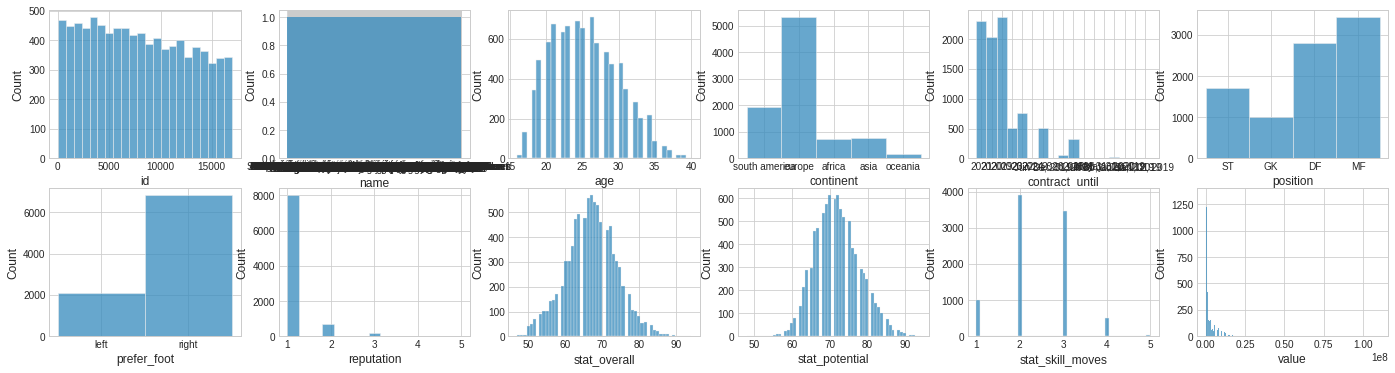

In [10]:
# 히스토그램
# 모든 항목에 대하여. 총 12가지. Label(value)  포함.
f, ax = plt.subplots(2,6, figsize=(24,6))
ax = ax.flatten()
col_list = list(fifa_train.columns)   
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


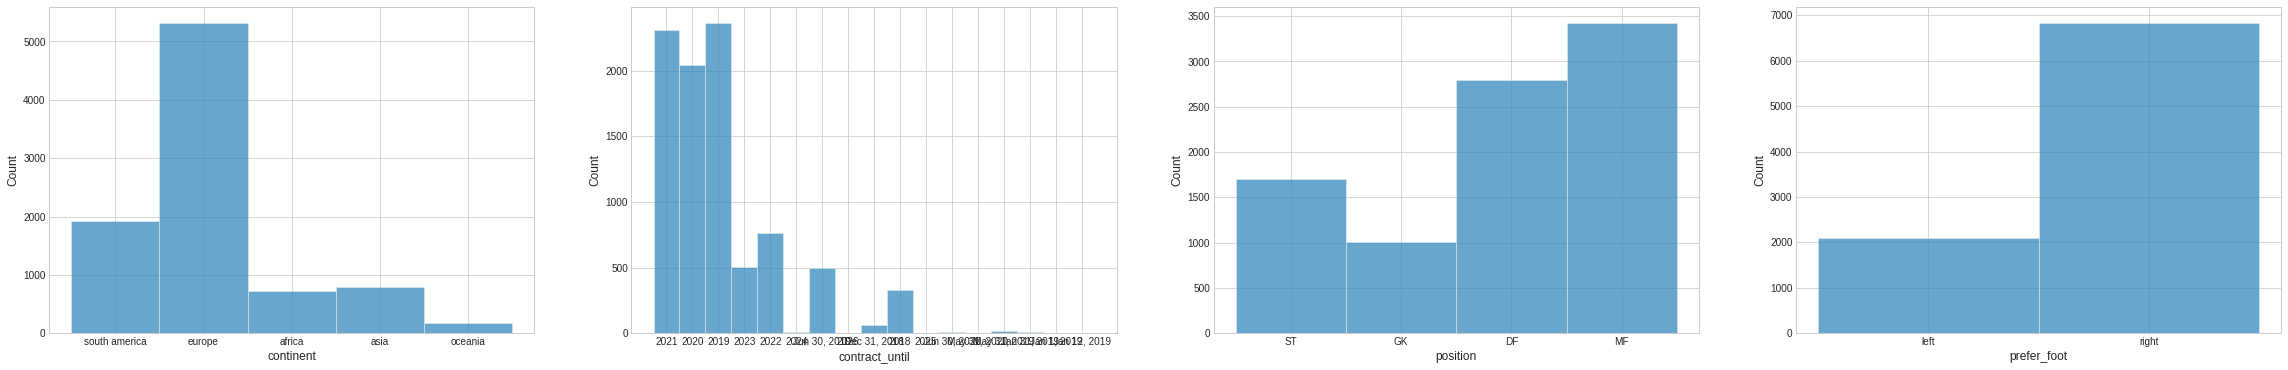

In [11]:
# 히스토그램
# 범주 항목에 대하여. 총 4가지.
f, ax = plt.subplots(1,4, figsize=(40,6))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


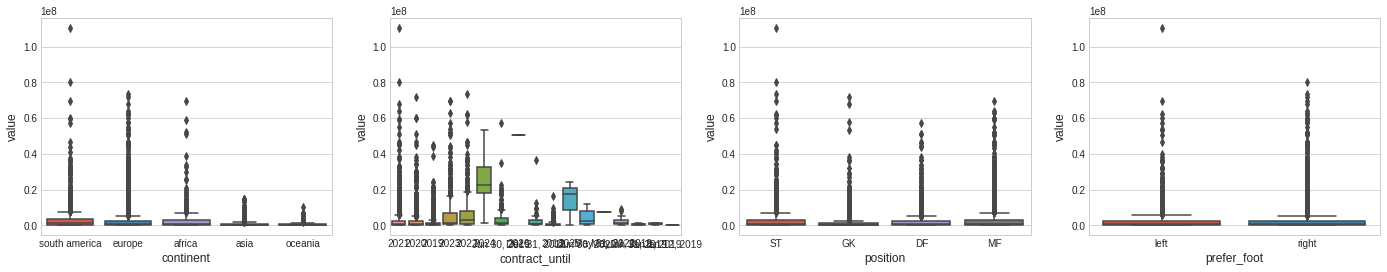

In [12]:
# 박스플롯
# 범주 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,4, figsize=(24,4))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


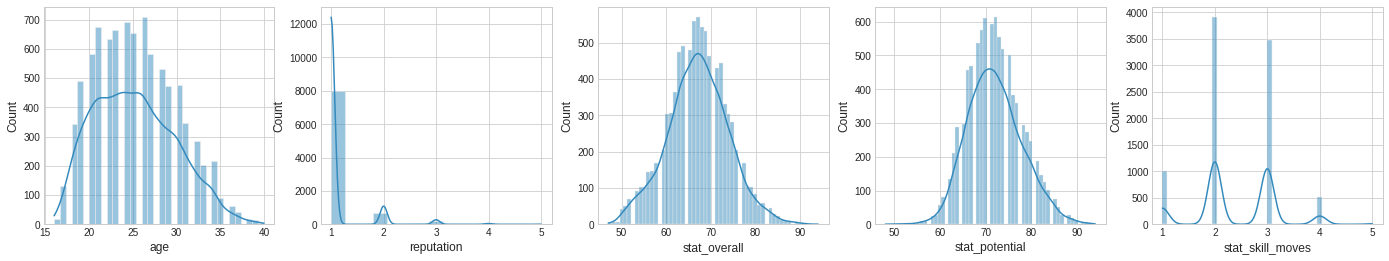

In [13]:
# 히스토그램
# 수치 항목에 대하여, 총 5가지
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i], kde=True)
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


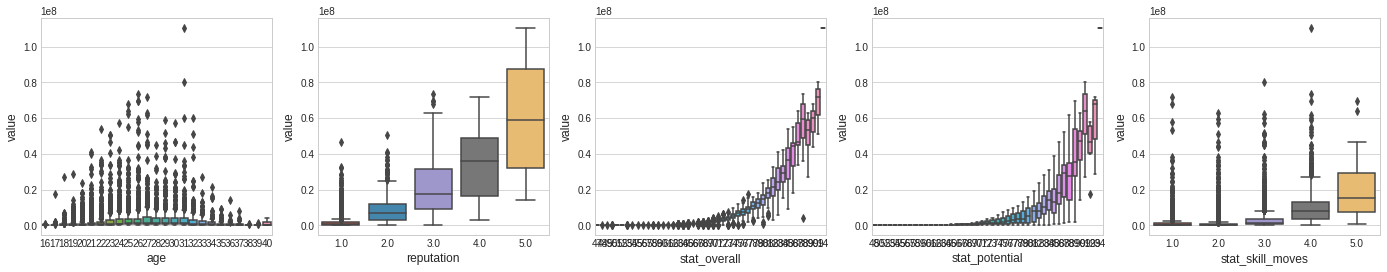

In [14]:
# 박스플롯
# 수치 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

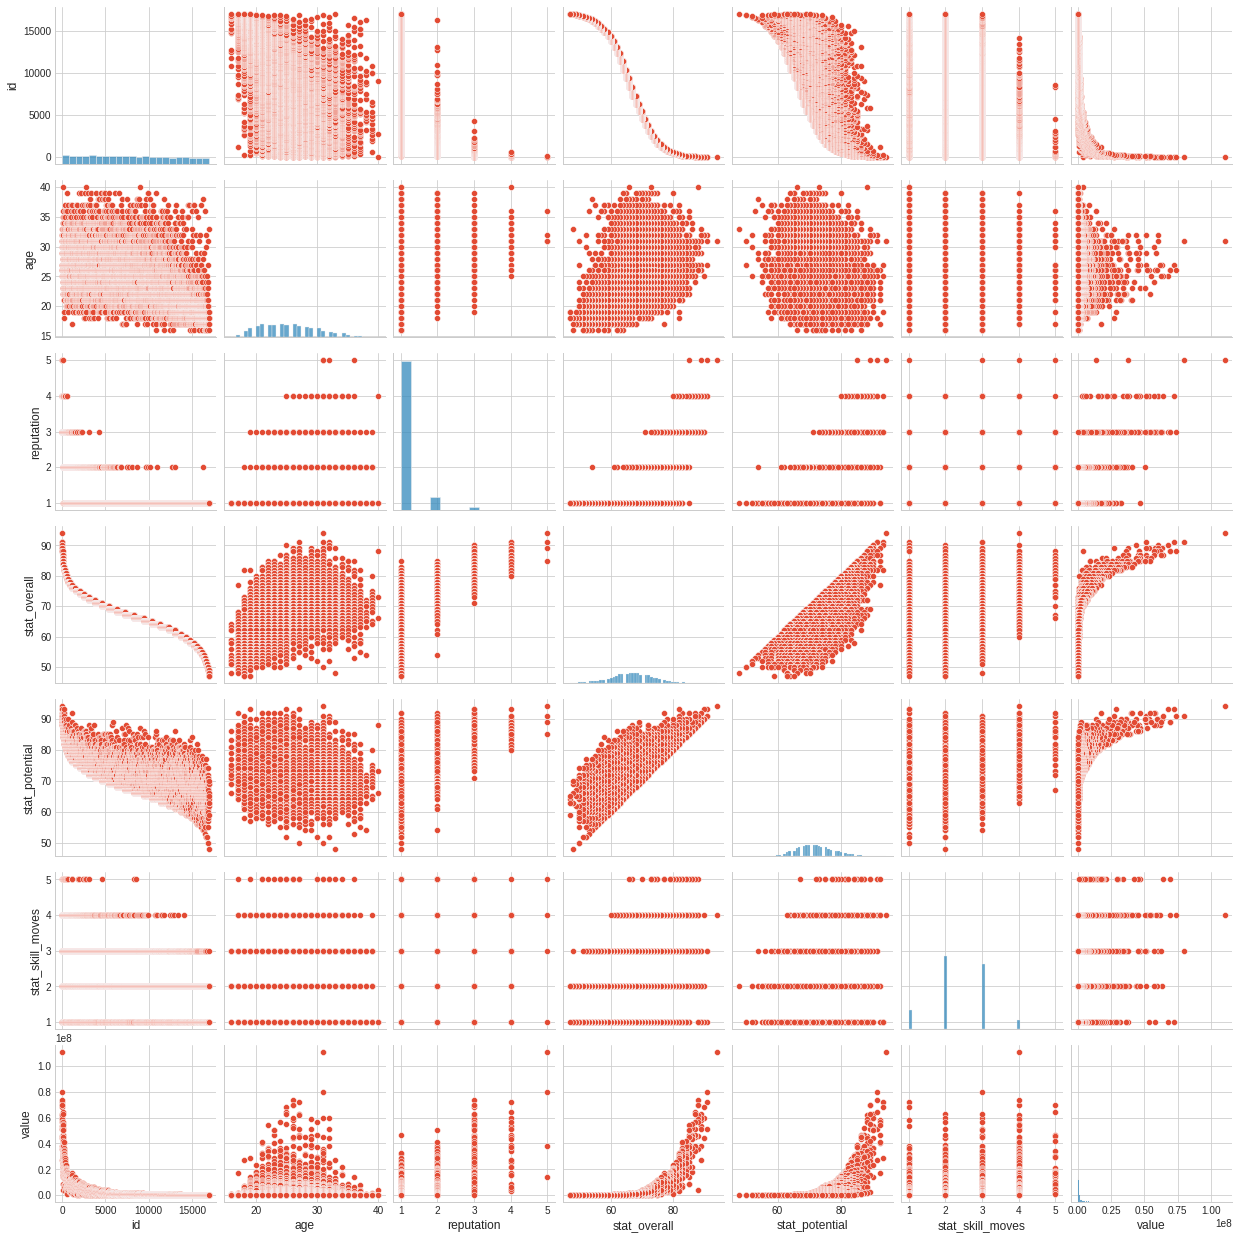

In [15]:
# 페어플롯(여러 변수간 산점도)
sns.pairplot(fifa_train,palette='dark')
plt.show()

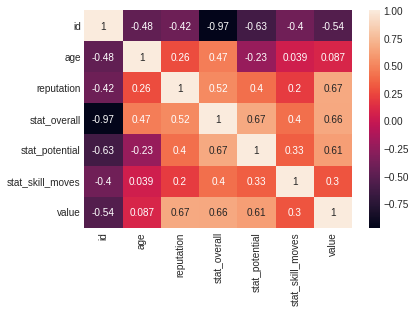

In [16]:
sns.heatmap(fifa_train.corr(), annot=True)
plt.show()

## 중간 회고
- 히트맵에서 몸값('value')을 기준으로 보았을 때, reputation, stat_overall, stat_potential 등은 0.5가 넘으므로 유의미한 상관관계가 있음을 알 수 있다.
- id는 해당없으므로 논외로 취급한다.
- 나이('age')는 현실에서 의미가 없을리가 없다. 하지만 실제로는 거의 없는 것에 가깝게 나온다. 이 부분에 상당한 의구심이 들었다.
- stat_skill_moves는 무슨 의미인지 잘 모르겠다. 그리고 상관관계도 0.3으로 없지는 않지만 낮은 편이어서 좀 더 알아볼 필요성을 느꼈다.

## (2) 데이터 분석 및 수정

### 1) 계약기간 변수 단위 변경

In [17]:
# 반영수치 조정: 월 단위로. 날짜는 반올림.
if transform_contract_until == True:

    def con_period(x):
        if x == 'Dec 31, 2018' :
            return 12
        elif x == 'Jun 30, 2020' :
            return 30
        elif x == 'Jun 30, 2019' :
            return 18
        elif x == 'May 31, 2020' :
            return 29
        elif x == 'May 31, 2019' :
            return 17
        elif x == 'Jan 31, 2019' :
            return 13
        elif x == 'Jan 1, 2019' :
            return 12
        elif x == 'Jan 12, 2019' :
            return 12
        elif x == 'Dec 31, 2019' :
            return 24
        elif x == 'Jun 1, 2019' :
            return 17
        else :
            return (int(x) - 2017)*12
    fifa_train.contract_until = fifa_train.contract_until.apply(con_period).astype('float64')
    fifa_test.contract_until = fifa_test.contract_until.apply(con_period).astype('float64')

# 초기 설정: 년 단위로.
else: 
    def con_period(x):
        if x == 'Dec 31, 2018' :
            return '2019'
        elif x == 'Jun 30, 2020' :
            return '2020.5'
        elif x == 'Jun 30, 2019' :
            return '2019.5'
        elif x == 'May 31, 2020' :
            return '2020.3333'
        elif x == 'May 31, 2019' :
            return '2019.3333'
        elif x == 'Jan 31, 2019' :
            return '2019.0833'
        elif x == 'Jan 1, 2019' :
            return '2019'
        elif x == 'Jan 12, 2019' :
            return '2019.034'
        elif x == 'Dec 31, 2019' :
            return '2020'
        elif x == 'Jun 1, 2019' :
            return '2019.416'
        else :
            return x
    fifa_train.contract_until = fifa_train.contract_until.apply(con_period).astype('float64') - 2018
    fifa_test.contract_until = fifa_test.contract_until.apply(con_period).astype('float64') - 2018

## 중간 회고
- __데이터 분석기준은 공유코드란에서 가져온 것을 기본으로 한다.__
- __수정한 데이터로 나온 RMSE값이 기준값보다 낮으면 빨간색으로 표기한다. 모델의 최소값은 Bold처리를 추가로 하였다.__
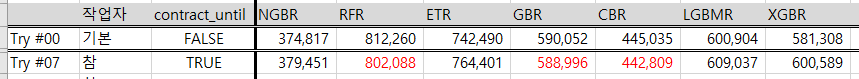
- 계약기간 수치화는 원본 코드에서는 시각화 이후에 진행되어 원본의 히트맵에 보이지만 않았을 뿐, 모델링 과정에서는 반영되었다.
- 원본코드에서는 년단위로 수행되었고, 이것이 날짜가 기재된 경우 소수점이 되고 연도가 계산에 들어가면 번거로워질 것 같아 남은 계약기간의 개월단위로 수정하기로 하였다.
- 계약기간이 일자까지 명시되어 있는 경우는 반올림하였다.
- 기간은 2018년 1월부터로 계산하여, 2018년 12월에 종료할 경우 12개월, 2019년일 경우 24개월, 2019년 1월 31일인 경우 25개월 등이다.
- 결과적으로 바꾸나 안 바꾸나 큰 차이는 없었다. 이미 유사개념이 적용되어서 보기 좋다는 것 이외의 실질 이득은 없다.

### 2) 'Position' 가중치화

In [18]:
if transform_position == True:
    
    adjusted_position = copy.deepcopy(fifa_train['position'])
    num_st = 0
    num_gk = 0
    num_df = 0
    num_mf = 0
    for i, term in enumerate(adjusted_position):
        if term == 'ST':
            num_st += 1
        elif term == 'GK':
            num_gk += 1
        elif term == 'DF':
            num_df += 1
        elif term == 'MF':
            num_mf += 1
    
    print(f'공격수는 총 {num_st}명입니다.')
    print(f'골키퍼는 총 {num_gk}명입니다.')
    print(f'수비수는 총 {num_df}명입니다.')
    print(f'미드필더는 총 {num_mf}명입니다.')
    total_length = len(adjusted_position)
    print(f'모든 선수의 수는 총 {total_length}명입니다.')
    
    # 공급의 비율: 해당 포지션 선수의 수 / 모든 선수의 수
    supplyratio_st = num_st/total_length
    supplyratio_gk = num_gk/total_length
    supplyratio_df = num_df/total_length
    supplyratio_mf = num_mf/total_length
    print(f'포지션 별 공급 비율: 공격 - {supplyratio_st}, 골키퍼 - {supplyratio_gk}, 수비수 - {supplyratio_df}, 미드필더 - {supplyratio_mf}')
    
    # 수요의 비율: 포메이션 구성에 따라 다르게 수정. (3,5,2), (4,4,2), (3,6,1) 등..
    demandratio_st = formation[2]/11
    demandratio_gk = 1/11
    demandratio_df = formation[0]/11
    demandratio_mf = formation[1]/11
    print(f'포지션 별 수요 비율: 공격 - {demandratio_st}, 골키퍼 - {demandratio_gk}, 수비수 - {demandratio_df}, 미드필더 - {demandratio_mf}')
    
    # 가중치: 수요/공급. 수요가 많으면 가중치 높음.
    weight_st = round((demandratio_st / supplyratio_st), 2)
    weight_gk = round((demandratio_gk / supplyratio_gk), 2)
    weight_df = round((demandratio_df / supplyratio_df), 2)
    weight_mf = round((demandratio_mf / supplyratio_mf), 2)
    print(f'포지션 별 수요/공급 가중치: 공격 - {weight_st}, 골키퍼 - {weight_gk}, 수비수 - {weight_df}, 미드필더 - {weight_mf}')
    
    def replace_position(adjusted_position):
        if adjusted_position == 'ST':
            return weight_st
        elif adjusted_position == 'GK':
            return weight_gk
        elif adjusted_position == 'DF':
            return weight_df
        elif adjusted_position == 'MF':
            return weight_mf
    adjusted_position = adjusted_position.apply(replace_position)
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,3.0,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2.0,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,3.0,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2.0,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,3.0,GK,right,3.0,90,93,1.0,68000000.0


## 중간 회고
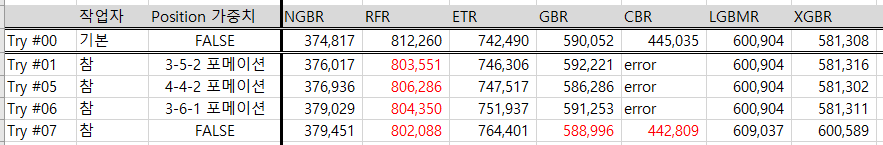
- 포지션은 범주 데이터(ST, GK, DF, MF)이고, 기본 설정은 원핫인코딩이다.
- 이를 수치 데이터로 변경하면 혹시 다를 수 있는지 고민하였고, 포지션 가중치로 놓기로 결정하였다.
- 여기서 선수의 전체 수를 공급 시장이라고 가정하고, 각각 '포지션 수/총 선수의 수'로 포지션별 공급비율을 계산하였다.
- 포메이션을 수요시장이라고 가정하고, 3-5-2, 4-4-2 등의 포메이션일 때 차지하는 각 포지션의 비율을 수요비율로 계산하였다.
- 포지션 가중치는 수요/공급으로 계산하여 수요가 많으면 더 높은 가중치를 부여하도록 하였다.
- RMSE는 RFR에 대해서 약간 하락하는 양상이 있었으나 나머지는 같거나 약간 증가하는 정도여서 전체적으로는 대동소이하였다. CBR은 작동하지 않았다. 
- 이 수치의 변경은 큰 도움이 되지 않은 것으로 생각된다.

### 3) 'Prefer_foot' 원핫 인코딩화

In [19]:
if transform_prefer_foot == True:
    
    def con_prefoot(x):
            if x == 'left':
                return True
            else :
                return False
            
    fifa_train.prefer_foot = fifa_train.prefer_foot.apply(con_prefoot).astype('float64')
    fifa_test.prefer_foot = fifa_test.prefer_foot.apply(con_prefoot).astype('float64')
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,3.0,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2.0,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,3.0,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2.0,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,3.0,GK,right,3.0,90,93,1.0,68000000.0


## 중간 회고
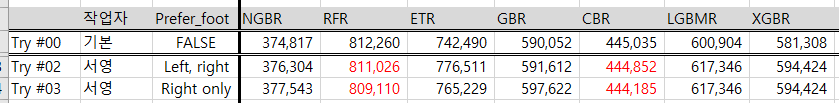
- 팀이 어느 한쪽 발만 선호하는 선수들로만 구성되어 있다면, 원활한 팀플레이가 어렵다. 윙 포지션에 있는 선수들은 더욱 그렇다. 따라서 수가 적은 왼발잡이 선수들이 특별대우를 받는지 확인해보고자 원핫 인코딩을 진행해 보았다.
- 한 번은 왼발잡이와 오른발잡이 컬럼을 별도로 만들고, 다른 한 번은 하나의 컬럼만 만들어 왼발 1, 오른발 0으로 놓고 비교해 보았다.
- 결과적으로는 아무런 상관관계가 없다. 몸값과의 상관관계는. 0.0047.
- RMSE값도 약간의 상하 변동이 있으나 대체로 비슷했다.

### 4) 'Age' 피크값 위치 바꾸기

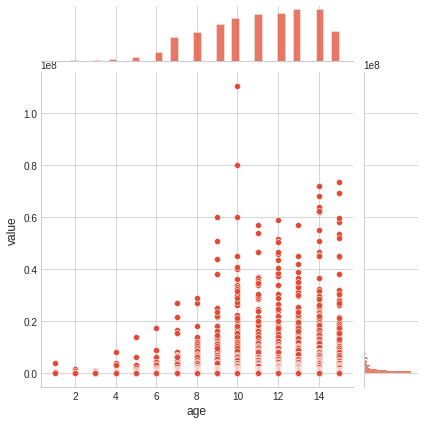

In [20]:
if transform_age == True:
    train_adj_age = []
    test_adj_age = []
    a = 26
    val_point = 15
    
    for i in fifa_train['age']:
        if a - i == 0:
            val_point = 15
            train_adj_age.append(val_point)
    
        elif a < i:
            val_point = 15 - (i-a)
            train_adj_age.append(val_point)
        elif a > i:
            val_point = 15 - (a-i)
            train_adj_age.append(val_point)
    
    fifa_train['age'] = train_adj_age
    
    for i in fifa_test['age']:
        if a - i == 0:
            val_point = 15
            test_adj_age.append(val_point)
    
        elif a < i:
            val_point = 15 - (i-a)
            test_adj_age.append(val_point)
        elif a > i:
            val_point = 15 - (a-i)
            test_adj_age.append(val_point)
    
    fifa_test['age'] = test_adj_age
fifa_train.head()
sns.jointplot(data=fifa_train, x="age", y='value')
plt.show()

## 중간 회고
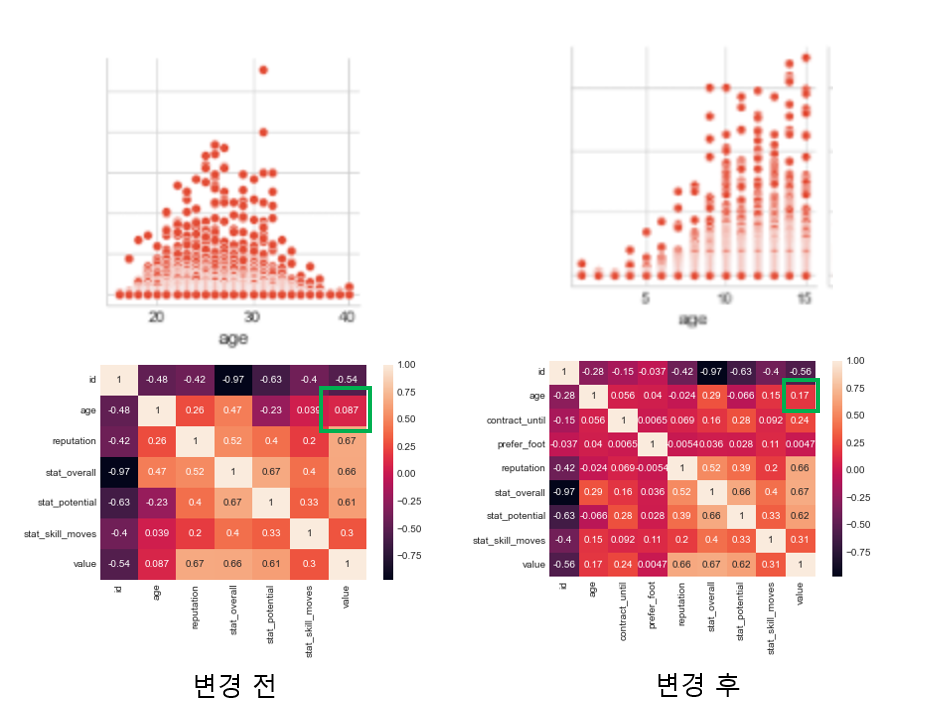

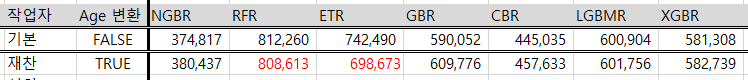
- 나이는 수치데이터이지만 최대값이 가운데(26세)에 몰려있어, 훈련에 큰 도움이 되지 않을 수도 있겠다는 예상을 하였다.
- 히트맵을 보았을 때, 나이 데이터가 원본상태에서는 0.087로 몸값과는 매우 낮은 상관관계를 보여주었다.
- 그래서 40살을 1점으로 하여, 어려질수록 1점을 더하고 몸값이 최대가 되는 26세 다음부터는 1점씩 줄이는 방법으로 나이 점수를 변환하였다.
- 변환 후의 나이는 몸값과의 상관관계가 0.17로 조금 더 높아졌다. 하지만 예상하던 0.5를 넘는 수치는 나오지 않았다. 이 부분은 추후 한 번 더 고민해볼 지점이다.
- RMSE 값도 기본값과 큰 차이가 없었다. 실질적인 차이는 없지는 않아도 매우 미미한 것으로 생각된다.

### 5) 'continent' 제거

In [21]:
if remove_continent == True:
    fifa_train.drop(['continent'], axis = 1, inplace = True)
    fifa_test.drop(['continent'], axis = 1, inplace = True)
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,10,south america,3.0,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,14,europe,2.0,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,10,south america,3.0,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,9,europe,2.0,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,14,europe,3.0,GK,right,3.0,90,93,1.0,68000000.0


## 중간 회고
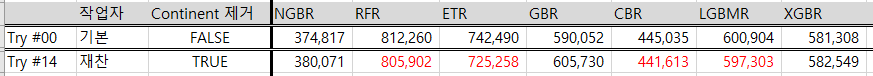
- 출신 대륙은 기본적으로 원핫인코딩으로 변환되어 모델링에 반영된다.
- 출신 대륙은 출신국과 유사하다고 보았을 때, 유럽은 출신국과 인종적 특성관계가 적은 편이다. 주어진 데이터상에는 이것이 나타나 있지 않으나, 우리가 매일 접하는 유럽 리그를 보면 흑인들 중에 유럽 출신이 상당히 많은 편이므로 출신국은 큰 영향을 주지 않을거라 예상하였다.
- 따라서 출신대륙을 제거해 보았을 때 유의미한 결과가 있는지 알아보고자 제거를 진행해 보았다.
- 결과는 아무런 변화가 없었다. 출신대륙이 큰 영향을 끼치지 않는다는 가설이 맞음을 확인하였다.

### 6) 'stat_skill_moves' 제거

In [22]:
if remove_stat_skill_moves == True:
    fifa_train.drop(['stat_skill_moves'], axis = 1, inplace = True)
    fifa_test.drop(['stat_skill_moves'], axis = 1, inplace = True)
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,10,south america,3.0,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,14,europe,2.0,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,10,south america,3.0,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,9,europe,2.0,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,14,europe,3.0,GK,right,3.0,90,93,1.0,68000000.0


## 중간회고
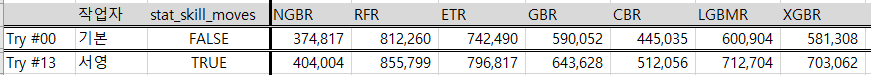
- stat_skill_moves는 여러 기술들의 합이다. 
- 이는 정확히 무슨 역할을 하는지 알기 힘들었다. 몸값과의 상관관계도 0.3으로 매우 낮아서 어떻게 처리할지 고민하다가, 우선 빼보기로 했다.
- 제외한 후 결과는 오히려 더 안 좋아졌다. 모든 RMSE값이 증가함을 알 수 있다.
- 넣기는 넣어야 하는데, 어떻게 할 것인가?

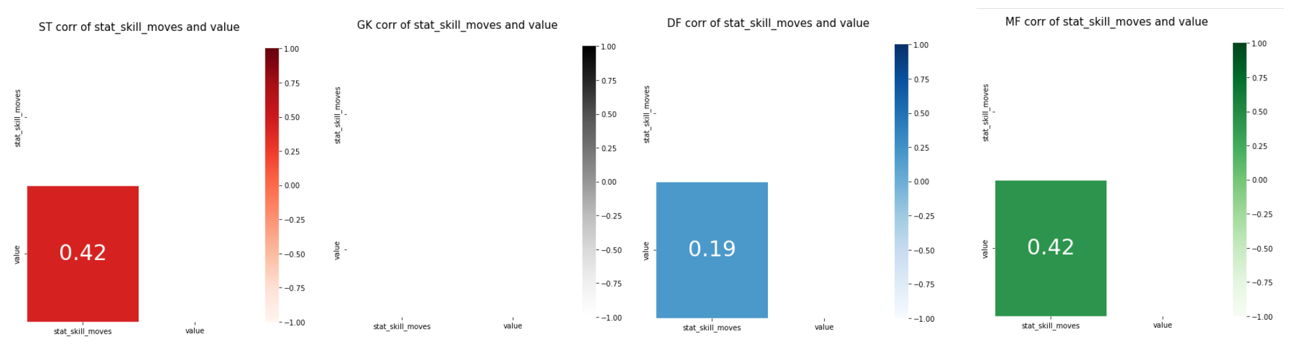
- 포지션 별로 스킬이 미치는 정도가 달라질 것이라는 의견이 있어, 포지션별 상관관계를 측정하였고, 그 결과 어느 정도 의미가 있음을 알 수 있었다.
- 해당 코드는 시간 관계상 통합코드에 반영하지는 못하였다.
- 공격수와 미드필더는 각각 0.42로 0.12 증가하였으며, 수비수는 0.19로 0.11 감소하였고 골키퍼는 아무 관계가 없었다(NaN).
- 이에 따라 예측도 포지션별로 나누어서 할 필요가 있다는 의견이 제기되었다. 하지만 구현에는 시간적 한계로 인해 더 진행하지 않았다.

### 7) 아웃라이어 삭제

In [23]:
if remove_outlier == True:
    sorted_fifa_train = fifa_train.sort_values(by = 'value', ascending = False)
    print('정렬된 데이터')
    sorted_fifa_train.head()


정렬된 데이터


In [24]:
if remove_outlier == True:
    sorted_fifa_train.tail()

In [25]:
if remove_outlier == True:
    # 아웃라이어 삭제. 
    sorted_fifa_train = sorted_fifa_train.iloc[top_outlier_num:bot_outlier_num]  # 리스트내 구간 수정으로 아웃라이어 구간 설정.
    fifa_train = sorted_fifa_train
    print('정렬되고 아웃라이어가 삭제된 데이터')
    sorted_fifa_train.head()

정렬되고 아웃라이어가 삭제된 데이터


In [26]:
if remove_outlier == True:
    sorted_fifa_train.tail()

## 중간 회고
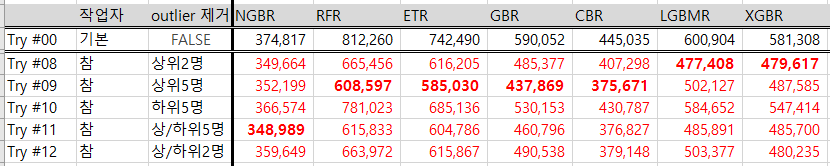
- 최상위 몸값의 선수들 2명(메시, 수아레즈)을 빼고 같은 설정으로 돌려보았더니 RMSE가 상당량 감소한 것을 확인해보았다.
- 일반화가 가능한지 확인하기 위해 추가로 다른 상/하위 몸값의 선수들을 배제하고 돌려보았더니 역시 효과가 있었다.
- 상위 5명을 제외하였을 때 전반적으로 4개 regressor에서 최소값이 나왔으며, 단일 regressor 최소값은 상/하위 5명을 제외했을 때 NGBR에서 나왔다.
- 이상치 제거는 전체 데이터 예측에서 필수적인 것으로 결론 내린다.

## (3) 수정된 데이터 시각화

['id', 'name', 'age', 'continent', 'contract_until', 'position', 'prefer_foot', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves', 'value']


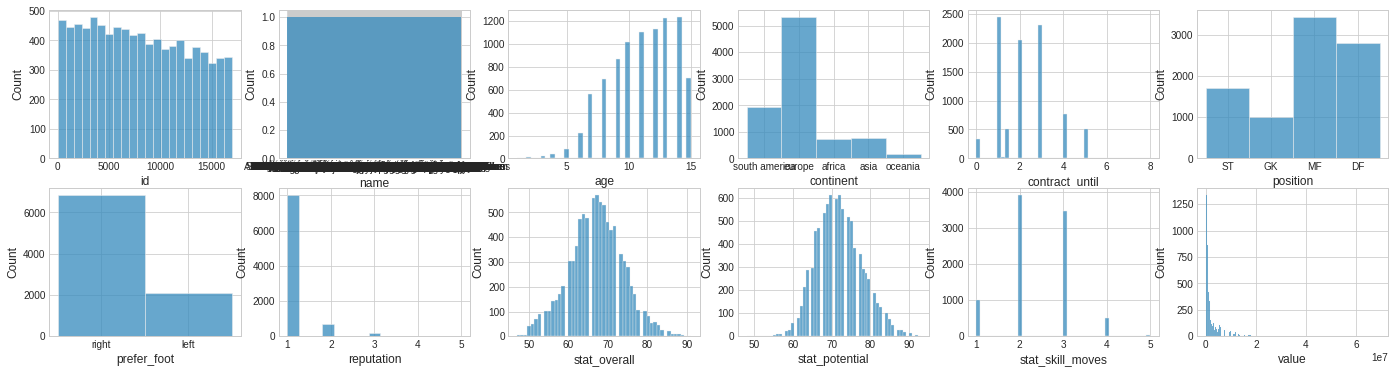

In [27]:
# 히스토그램
# 모든 항목에 대하여. 총 12가지. Label(value)  포함.
f, ax = plt.subplots(2,6, figsize=(24,6))
ax = ax.flatten()
col_list = list(fifa_train.columns)   
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


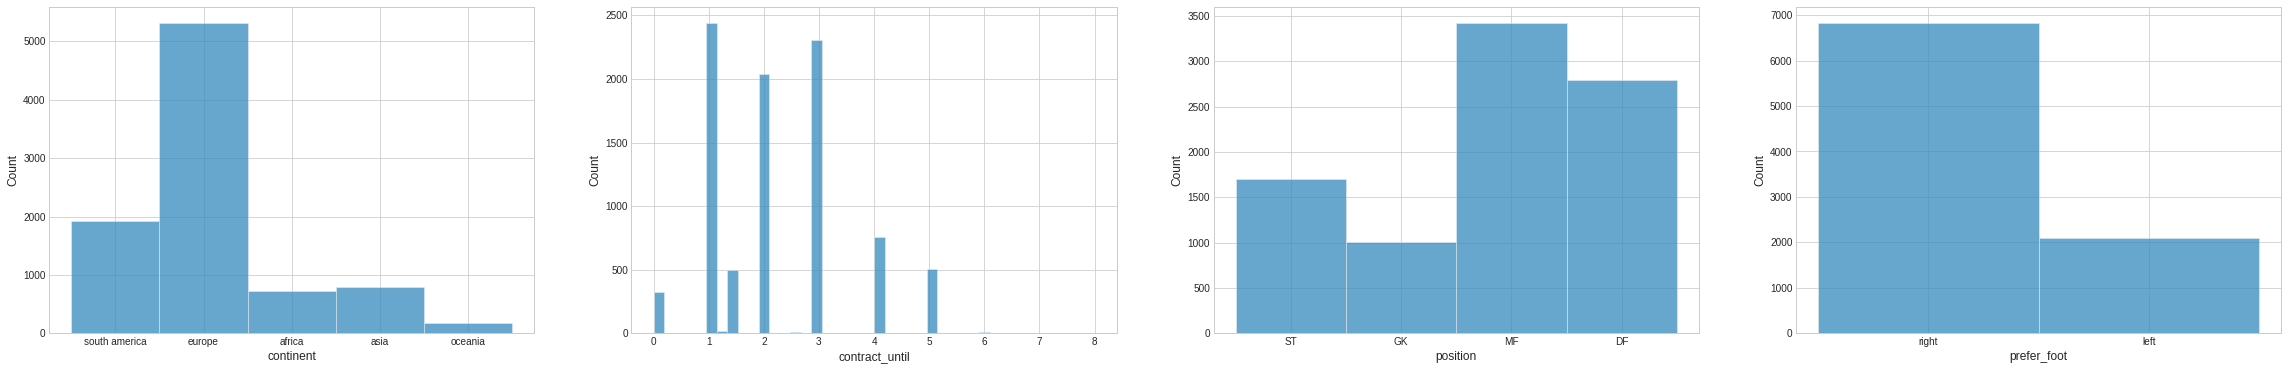

In [28]:
# 히스토그램
# 범주 항목에 대하여. 총 4가지.
f, ax = plt.subplots(1,4, figsize=(40,6))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


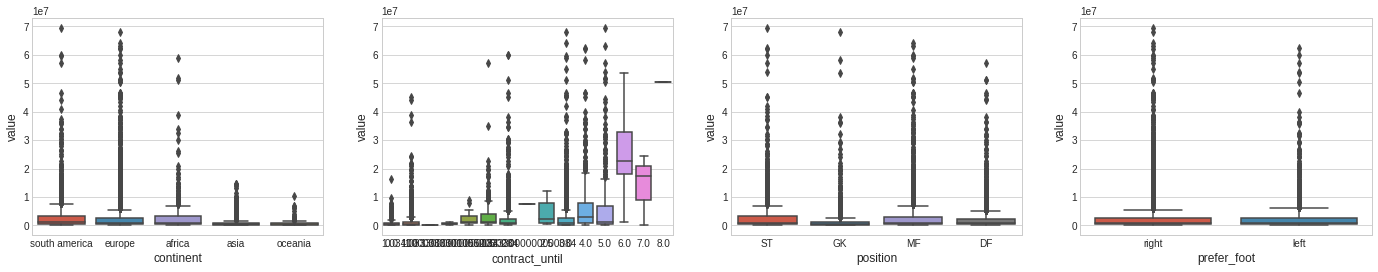

In [29]:
# 박스플롯
# 범주 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,4, figsize=(24,4))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


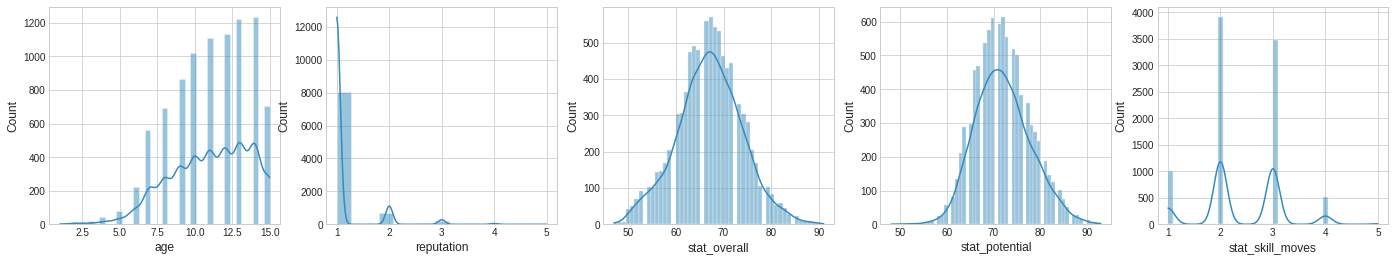

In [30]:
# 히스토그램
# 수치 항목에 대하여, 총 5가지
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i], kde=True)
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


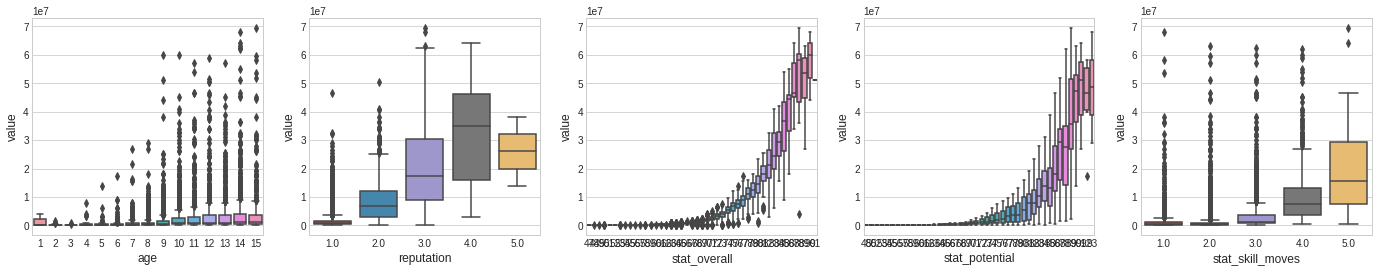

In [31]:
# 박스플롯
# 수치 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

In [32]:
# # 페어플롯(여러 변수간 산점도)
# sns.pairplot(fifa_train,palette='dark')
# plt.show()

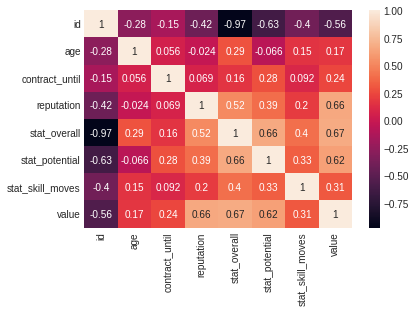

In [33]:
sns.heatmap(fifa_train.corr(), annot=True)
plt.show()

## 중간 회고
- 계약기간('contract_until') 및 주 사용발(prefer_foot)이 수치화됨에 따라 히트맵에 추가되었다.
- 위에 언급하였듯, 'age'는 변환후 몸값과의 상관도가 증가하였다.

# 3. 훈련 및 평가
## (1) 훈련 전처리

In [34]:
# Log transformation
fifa_train[['contract_until', 'stat_overall', 'stat_potential', 'value']] = np.log1p(fifa_train[['contract_until', 'stat_overall', 'stat_potential', 'value']])
fifa_test[['contract_until', 'stat_overall', 'stat_potential']] = np.log1p(fifa_test[['contract_until', 'stat_overall', 'stat_potential']])

# 범주항목 원핫 인코딩 - prefer_foot
if transform_prefer_foot != True:
    fifa_train.drop(['prefer_foot'], axis=1, inplace = True)
    fifa_test.drop(['prefer_foot'], axis=1, inplace = True)

# 훈련 미반영 컬럼 삭제 및 Label 분리
X = fifa_train.drop(['id', 'name', 'value'], axis=1)
y = fifa_train['value']
target = fifa_test.drop(['id', 'name'], axis=1)

# 범주항목 원핫 인코딩 - transform_position
if transform_position != True:
    X = pd.get_dummies(columns = ['position'], data = X)
    target = pd.get_dummies(columns = ['position'], data = target)
    
# 범주항목 원핫 인코딩 - remove_continent
if remove_continent != True:
    X = pd.get_dummies(columns = ['continent'], data = X)
    target = pd.get_dummies(columns = ['continent'], data = target)
    


## (2) 모델 훈련 - 전체

In [35]:
# 1) NGBRegressor
ngb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(target)]) / 10
    ngb_pred += sub_pred
print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

[iter 0] loss=1.7554 val_loss=0.0000 scale=1.0000 norm=1.2848
[iter 100] loss=-1.0600 val_loss=0.0000 scale=1.0000 norm=0.4664
[iter 200] loss=-1.1917 val_loss=0.0000 scale=1.0000 norm=0.4827
[iter 300] loss=-1.2748 val_loss=0.0000 scale=1.0000 norm=0.4779
[iter 400] loss=-1.3360 val_loss=0.0000 scale=1.0000 norm=0.4781
[iter 500] loss=-1.3933 val_loss=0.0000 scale=1.0000 norm=0.4788
[iter 600] loss=-1.4380 val_loss=0.0000 scale=1.0000 norm=0.4815
[iter 700] loss=-1.4819 val_loss=0.0000 scale=1.0000 norm=0.4877
[iter 800] loss=-1.5056 val_loss=0.0000 scale=1.0000 norm=0.4882
[iter 900] loss=-1.5265 val_loss=0.0000 scale=0.2500 norm=0.1221
[iter 0] loss=-1.4943 val_loss=0.0000 scale=0.5000 norm=0.2717
[iter 100] loss=-1.5546 val_loss=0.0000 scale=0.5000 norm=0.2456
[iter 200] loss=-1.5735 val_loss=0.0000 scale=1.0000 norm=0.4911
[iter 300] loss=-1.5917 val_loss=0.0000 scale=0.5000 norm=0.2453
[iter 400] loss=-1.6041 val_loss=0.0000 scale=0.0039 norm=0.0019
[iter 500] loss=-1.6102 val_lo

In [36]:
# 2) RFRegressor
rf_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)]) / 10
    rf_pred += sub_pred
print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

RandomForestRegressor의 10fold 평균 RMSE는 628155.8319866078


In [37]:
# 3) ExtraTreeRegressor
etc_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    etc.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(target)]) / 10
    etc_pred += sub_pred
print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

ExtraTreesRegressor의 10fold 평균 RMSE는 580090.2659960847


In [38]:
# 4) GradientBosstingRegressor
gb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(target)]) / 10
    gb_pred += sub_pred
print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

GradientBoostingRegressor의 10fold 평균 RMSE는 441372.5582796483


In [39]:
# 5) CatBoostRegressor
cb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(target)]) / 10
    cb_pred += sub_pred
print(f'{cb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

CatBoostRegressor의 10fold 평균 RMSE는 501310.84659820626


In [40]:
# 6) LGBMRegressor
lgbm_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)]) / 10
    lgbm_pred += sub_pred
print(f'{lgbm.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

LGBMRegressor의 10fold 평균 RMSE는 483148.396865148


In [41]:
# 7) XGBRegressor
xgb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)]) / 10
    xgb_pred += sub_pred
print(f'{xgb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

XGBRegressor의 10fold 평균 RMSE는 516678.14920788584


In [42]:
# Blending models
submission['value'] = (gb_pred + rf_pred + etc_pred + lgbm_pred + cb_pred + ngb_pred + xgb_pred) / 7
q1 = submission['value'].quantile(0.004)
q2 = submission['value'].quantile(0.99)

submission['value'] = submission['value'].apply(lambda x: x if x > q1 else x * 0.9)
submission['value'] = submission['value'].apply(lambda x: x if x < q2 else x * 1.1)

print( "결과를 기록합니다..." )
submission.to_csv('sub_integrated{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

print( "\n기록 완료.")

end_time = time.time()
work_time = int((end_time - start_time)//60)
print(f'총 작업시간은 약 {work_time}분입니다.')

결과를 기록합니다...

기록 완료.
총 작업시간은 약 13분입니다.


## 모델 하이퍼 파라미터 값에 대한 회고

시간관계상 모든 모델의 파라미터 값을 변경해보지는 못하였고 NGBR, RFR,ETR, GBR 네 모델의 파라미터 값만 변경해 주었다.
모든 파라미터 값을 변경하지 못하였고 성능에 영향을 가장많이 주는 n_estimators를 위주로 실험 하였다. 예상대로 성능이 올라가긴 했으나 RFR은 오히려 떨어졌고 ETR의 경우는 차이가 없는 수준으로 미약한 발전이 있었다.

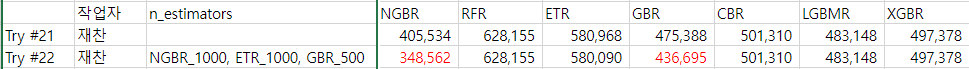

In [4]:
Image("../aiffel/hyperparameter.png")

그 이외에 NGBR, GBR의 learning_rate값에 변화를 주었는데 NGBR의 성능은 올라갔고 GBR의 성능은 훨씬 떨어졌다.
GBM같은 경우는 너무 작게 설정되어 업데이트 되는 값이 작아져 성능이 떨어진 것으로 생각된다. 

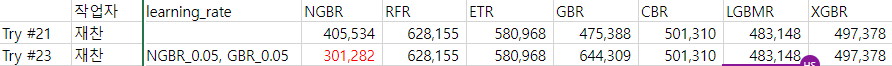

In [6]:
Image("../aiffel/learning_rate.png")

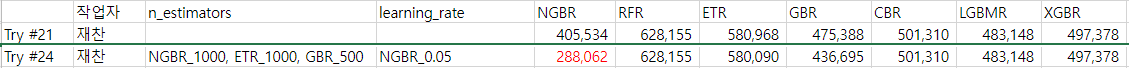

In [43]:
Image("../aiffel/both.png")

n_estimators와 learning_rate 두가지 모두 변경해서 해본 결과 NGBR의 값이 눈에 띄게 줄어든것을 확인할 수 있다.

CatBoostRegressor: 기본 파라미터가 기본적으로 최적화가 잘 되어 있어서 파라미터 튜닝에 신경쓰지 않아도 된다고 한다. 굳이 한다면 learning_rate, random_strength, L2_regularizer 과 같은 것들인데, 결과에서 큰 차이가 나지는 않는다고 한다.
이러한 이유로 하이퍼 파라미터의 값을 수정하지 않았다.

LGBM(LightBoost): 이 모델은 작은 데이터일때 과적합이 일어나기 쉽다고 한다. 통상적으로 10,000개 이하일 때 작은 데이터라 하는데 FIFA_train 데이터의 경우 8,932개의 데이터밖에 없어서 이 모델을 사용하기 적합하지 않다고 판단해 하이퍼 파라미터의 값에 변화를 주지 않았다.